In [1]:
!pip install datasets transformers pandas numpy nltk scikit-learn spacy matplotlib seaborn requests beautifulsoup4 google-search-results


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.7 MB/s eta 0:00:00
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32009 sha256=64f426c3a09a54e08677e57ba829639566c2493941627f2441142fd5b251ac5e
  Stored in directory: /root/.cache/pip/wheels/6e/42/3e/aeb691b02cb7175ec70e2da04b5658d4739d2b41e5f73cd06f
Successfully built google-search-results


Fetch financial Tweets using Twitter API

In [3]:

from datasets import load_dataset
import pandas as pd


# Load the Twitter Financial News Sentiment dataset from Hugging Face
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

# Convert the dataset to a Pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Display first few rows
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

sent_train.csv:   0%|          | 0.00/859k [00:00<?, ?B/s]

sent_valid.csv:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [4]:
# Preprocess and clean the text data (removes stopwords, punctuation, and converts to lowercase)
import nltk
from nltk.corpus import stopwords
import re

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Display cleaned data
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,label,cleaned_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reels expectations beyond meat h...
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura points bookings weakness carniv...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cuts neutral httpstcomcyftsxcn
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slides piper jaffray pt cut httpstc...


In [5]:
# Perform sentiment analysis using FinBERT (Classifies tweets as Positive, Neutral, or Negative)
from transformers import pipeline

# Load FinBERT Sentiment Analysis Model
sentiment_pipeline = pipeline("text-classification", model="yiyanghkust/finbert-tone")

# Analyze sentiment of financial tweets
df["predicted_sentiment"] = df["cleaned_text"].apply(lambda text: sentiment_pipeline(text)[0]["label"])

# Display results
df.head()



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,text,label,cleaned_text,predicted_sentiment
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reels expectations beyond meat h...,Neutral
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura points bookings weakness carniv...,Negative
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...,Negative
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cuts neutral httpstcomcyftsxcn,Neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slides piper jaffray pt cut httpstc...,Neutral


In [6]:
# Extract financial entities such as company names and stock symbols using Named Entity Recognition (NER)
import spacy

# Load SpaCy's pre-trained NLP model
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    """Extract named entities from financial tweets"""
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER to the tweets
df["entities"] = df["cleaned_text"].apply(extract_entities)

# Display results
df.head()

,text,label,cleaned_text,predicted_sentiment,entities
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reels expectations beyond meat h...,Neutral,"[(jpmorgan, PERSON)]"
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura points bookings weakness carniv...,Negative,[(ccl rcl nomura points bookings weakness carn...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...,Negative,[]
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cuts neutral httpstcomcyftsxcn,Neutral,[]
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slides piper jaffray pt cut httpstc...,Neutral,[]


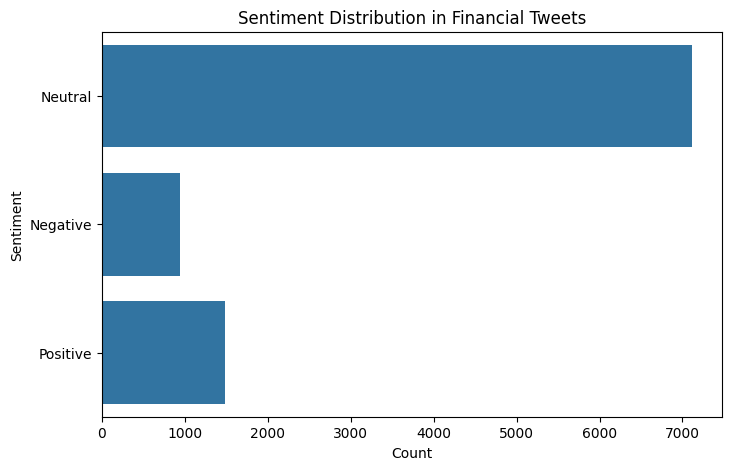

In [7]:
# Visualize the sentiment distribution using a bar chart
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(y=df["predicted_sentiment"])
plt.title("Sentiment Distribution in Financial Tweets")
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.show()

In [10]:
print(df.columns)

Index(['text', 'label', 'cleaned_text', 'predicted_sentiment', 'entities'], dtype='object')


In [11]:
import numpy as np
import pandas as pd

# Generate random past dates (assuming the dataset spans 30 days)
df["date"] = pd.to_datetime("2024-01-01") + pd.to_timedelta(np.random.randint(0, 30, size=len(df)), unit='D')

# Extract only the date (without time)
df["date"] = df["date"].dt.date

# Display updated DataFrame
df.head()


,text,label,cleaned_text,predicted_sentiment,entities,date
0,$BYND - JPMorgan reels in expectations on Beyo...,0,bynd jpmorgan reels expectations beyond meat h...,Neutral,"[(jpmorgan, PERSON)]",2024-01-02
1,$CCL $RCL - Nomura points to bookings weakness...,0,ccl rcl nomura points bookings weakness carniv...,Negative,[(ccl rcl nomura points bookings weakness carn...,2024-01-19
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,cx cemex cut credit suisse jp morgan weak buil...,Negative,[],2024-01-05
3,$ESS: BTIG Research cuts to Neutral https://t....,0,ess btig research cuts neutral httpstcomcyftsxcn,Neutral,[],2024-01-18
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,fnko funko slides piper jaffray pt cut httpstc...,Neutral,[],2024-01-20


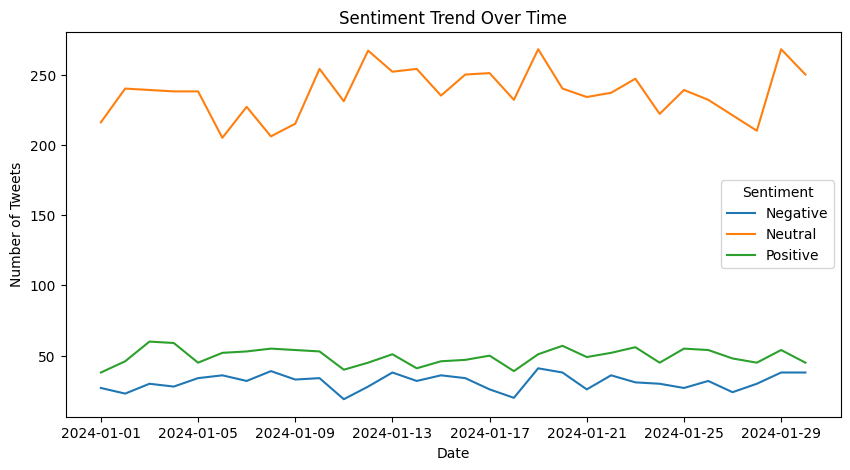

In [12]:
import matplotlib.pyplot as plt

# Group by date and count sentiment occurrences
sentiment_trend = df.groupby(['date', 'predicted_sentiment']).size().unstack()

# Plot sentiment trend
sentiment_trend.plot(kind='line', figsize=(10,5))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(title="Sentiment")
plt.show()
